This colab has an [accompanying video](https://www.youtube.com/watch?v=o6JNHoGUXCo)

In [1]:
!pip install open_spiel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 10.8 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94508 sha256=37bf149214d6563658bcacdeca485e605df96de4cdd9ad6b5d04121b6f3ddce9
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [2]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import pyspiel

from open_spiel.python.algorithms import exploitability
from open_spiel.python import policy as policy_lib

np.set_printoptions(precision=3, suppress=True, floatmode='fixed')

In [3]:
game = pyspiel.load_game('kuhn_poker')
state = game.new_initial_state()

print(state)
while not state.is_terminal():
  action = np.random.choice(state.legal_actions())
  print(f'Taking action {action} {state.action_to_string(action)}')
  state.apply_action(action)
  print(state)
print(f'Game over; returns {state.returns()}')


Taking action 2 Deal:2
2
Taking action 0 Deal:0
2 0
Taking action 0 Pass
2 0 p
Taking action 0 Pass
2 0 pp
Game over; returns [1.0, -1.0]


In [4]:
game = pyspiel.load_game('kuhn_poker')
print(game.get_type().pretty_print())

short_name: kuhn_poker
long_name: Kuhn Poker
dynamics: Sequential
chance_mode: ExplicitStochastic
information: ImperfectInformation
utility: ZeroSum
reward_model: Terminal
max_num_players: 10
min_num_players: 2
provides_information_state_string: true
provides_information_state_tensor: true
provides_observation_string: true
provides_observation_tensor: true
provides_factored_observation_string: true
parameter_specification: players=kInt***2***false


In [5]:
policy = policy_lib.TabularPolicy(game)
print(policy.states_per_player)
print(policy.action_probability_array)

[['0', '0pb', '1', '1pb', '2', '2pb'], ['1p', '1b', '2p', '2b', '0p', '0b']]
[[0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]]


In [6]:
def print_policy(policy):
  for state, probs in zip(it.chain(*policy.states_per_player),
                          policy.action_probability_array):
    print(f'{state:6}   p={probs}')

print_policy(policy)

0        p=[0.500 0.500]
0pb      p=[0.500 0.500]
1        p=[0.500 0.500]
1pb      p=[0.500 0.500]
2        p=[0.500 0.500]
2pb      p=[0.500 0.500]
1p       p=[0.500 0.500]
1b       p=[0.500 0.500]
2p       p=[0.500 0.500]
2b       p=[0.500 0.500]
0p       p=[0.500 0.500]
0b       p=[0.500 0.500]


In [7]:
print(exploitability.nash_conv(game, policy))

0.9166666666666666


In [8]:
def new_reach(so_far, player, action_prob):
  """Returns new reach probabilities."""
  new = np.array(so_far)
  new[player] *= action_prob
  return new

def calc_cfr(state, reach):
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    return state.returns()
  elif state.is_chance_node():
    return sum(prob * calc_cfr(state.child(action), new_reach(reach, -1, prob))
               for action, prob in state.chance_outcomes())
  else:
    # We are at a player decision point.
    player = state.current_player()
    #print('player', player)
    index = policy.state_index(state)

    # Compute utilities after each action, updating regrets deeper in the tree.
    utility = np.zeros((game.num_distinct_actions(), game.num_players()))

    for action in state.legal_actions():
      prob = curr_policy[index][action]
      utility[action] = calc_cfr(state.child(action), new_reach(reach, player, prob))
    # Compute regrets at this state.
    cfr_prob = np.prod(reach[:player]) * np.prod(reach[player+1:])
    value = np.einsum('ap,a->p', utility, curr_policy[index])
    #print('value',value)
    #print('value',utility[action][player])
    for action in state.legal_actions():
      regrets[index][action] += cfr_prob * (utility[action][player] - value[player])

    # Return the value of this state for all players.
    return value

In [ ]:
game = pyspiel.load_game('kuhn_poker')
policy = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy = policy.action_probability_array.copy()
regrets = np.zeros_like(policy.action_probability_array)
eval_steps = []
eval_nash_conv = []
for step in range(100):
  # Compute regrets
  calc_cfr(initial_state, np.ones(1 + game.num_players()))

  # Find the new regret-matching policy
  floored_regrets = np.maximum(regrets, 1e-16)
  sum_floored_regrets = np.sum(floored_regrets, axis=1, keepdims=True)
  curr_policy = floored_regrets / sum_floored_regrets

  # Update the average policy
  lr = 1 / (1 + step)
  policy.action_probability_array *= (1 - lr)
  policy.action_probability_array += curr_policy * lr

  # Evaluate the average policy
  if step & (step-1) == 0:
    nc = exploitability.nash_conv(game, policy)
    eval_steps.append(step)
    eval_nash_conv.append(nc)
    print(f'Nash conv after step {step} is {nc}')

TypeError: can't multiply sequence by non-int of type 'float'

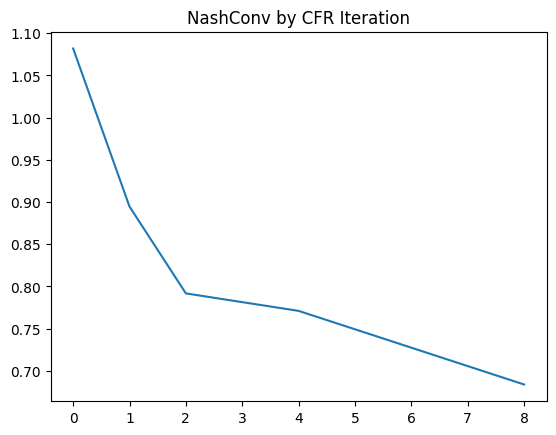

In [ ]:
fig, ax = plt.subplots()
ax.set_title("NashConv by CFR Iteration")
ax.plot(eval_steps, eval_nash_conv)
fig.show()

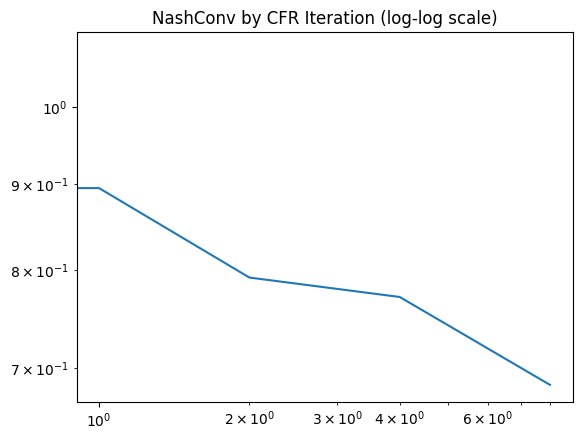

In [ ]:
fig, ax = plt.subplots()
ax.set_title("NashConv by CFR Iteration (log-log scale)")
ax.loglog(eval_steps, eval_nash_conv)
fig.show()

In [ ]:
# Display the whole policy
print_policy(policy)

# # How likely are we to bet with a Jack?
# alpha = policy.action_probability_array[policy.state_lookup['0']][1]
# print(f'P(bet with Jack) = alpha = {alpha:.3}')

# # How likely are we to bet with a King?
# pK = policy.action_probability_array[policy.state_lookup['2']][1]
# print(f'P(bet with King) = {pK:.3}, cf {alpha * 3:.3}')

# # How likely are we to call with a Queen?
# pQ = policy.action_probability_array[policy.state_lookup['1pb']][1]
# print(f'P(call with Queen after checking) = {pQ:.3}, cf {alpha + 1/3:.3}')


Streaming output truncated to the last 5000 lines.
4 1-4 1-6 2-2 2-3 2-5 2-6   p=[0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.865]
4 1-4 1-6 2-2 2-3 2-4 2-5   p=[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 1.000]
4 1-4 1-6 2-2 2-3 2-4 2-6   p=[0.043 0.043 0.043 0.043 0.043 0.043 0.043 0.043 0.043 0.043 0.043 0.043
 0.480]
4 1-4 1-6 2-2 2-4   p=[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.203 0.452
 0.344]
4 1-4 1-6 2-2 2-4 2-5 2-6   p=[0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.867]
4 1-4 1-6 2-3 2-5   p=[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 1.000]
4 1-4 1-6 2-3 2-6   p=[0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.869]
4 1-4 1-6 2-3 2-4   p=[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.272 0.278
 0.449]
4 1-4 1-6 2-3 2-4 2-5 2-6   p=[0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.

KeyboardInterrupt: 

In [9]:
def sample(actions_and_probs):
  actions, probs = zip(*actions_and_probs)
  return np.random.choice(actions, p=probs)

def policy_as_list(policy, state):
  return list(enumerate(policy.policy_for_key(state.information_state_string())))

def env_action(state):
  if state.is_chance_node():
    p = state.chance_outcomes()
  else:
    p = policy_as_list(fixed_policy, state)
  return sample(p)

def softmax(x):
  x = np.exp(x - np.max(x, axis=-1, keepdims=True))
  return x / np.sum(x, axis=-1, keepdims=True)

def generate_trajectory(state, player):
  trajectory = []
  while not state.is_terminal():
    if state.current_player() == player:
      action = sample(policy_as_list(rl_policy, state))
      trajectory.append((rl_policy.state_index(state), action))
    else:
      action = env_action(state)
    state.apply_action(action)
  return trajectory, state.returns()[player]


In [10]:
fixed_policy = policy_lib.TabularPolicy(game)
rl_policy = policy_lib.TabularPolicy(game)
for _ in range(5):
  print(generate_trajectory(game.new_initial_state(), player=0))

([(0, 1)], 1.0)
([(4, 1)], 2.0)
([(2, 1)], 1.0)
([(4, 0), (5, 1)], 2.0)
([(2, 0), (3, 0)], -1.0)


In [13]:
# Run REINFORCE
N = 70000
lr = 0.01
for step in range(N):
  for player in (0, 1):
    trajectory, reward = generate_trajectory(game.new_initial_state(), player)
    for s, a in trajectory:
      logits = np.log(rl_policy.action_probability_array[s])
      logits[a] += lr * reward
      rl_policy.action_probability_array[s] = softmax(logits)

In [14]:
# Evaluate the policy
def evaluate(state, rl_policy, player):
  if state.is_terminal():
    return state.returns()[player]
  elif state.current_player() == player:
    ap = policy_as_list(rl_policy, state)
  elif state.is_chance_node():
    ap = state.chance_outcomes()
  else:
    ap = policy_as_list(fixed_policy, state)
  return sum(p * evaluate(state.child(a), rl_policy, player) for a, p in ap)

def eval(rl_policy):
  return (evaluate(game.new_initial_state(), rl_policy, player=0)
        + evaluate(game.new_initial_state(), rl_policy, player=1))

print_policy(rl_policy)
eval(rl_policy)

0        p=[0.273 0.727]
0pb      p=[0.668 0.332]
1        p=[0.000 1.000]
1pb      p=[0.483 0.517]
2        p=[0.000 1.000]
2pb      p=[0.308 0.692]
1p       p=[0.000 1.000]
1b       p=[0.001 0.999]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.316 0.684]
0b       p=[0.652 0.348]


0.7717103355502349

0        p=[0.792 0.208]
0pb      p=[1.000 0.000]
1        p=[0.999 0.001]
1pb      p=[0.450 0.550]
2        p=[0.391 0.609]
2pb      p=[0.000 1.000]
1p       p=[0.999 0.001]
1b       p=[0.669 0.331]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.660 0.340]
0b       p=[1.000 0.000]
P(bet with Jack) = alpha = 0.208
P(bet with King) = 0.609, cf 0.623
P(call with Queen after checking) = 0.55, cf 0.541


alpha = policy.action_probability_array[policy.state_lookup['0']][1]
print(f'P(bet with Jack) = alpha = {alpha:.3}')

# How likely are we to bet with a King?
pK = policy.action_probability_array[policy.state_lookup['2']][1]
print(f'P(bet with King) = {pK:.3}, cf {alpha * 3:.3}')

# How likely are we to call with a Queen?
pQ = policy.action_probability_array[policy.state_lookup['1pb']][1]
print(f'P(call with Queen after checking) = {pQ:.3}, cf {alpha + 1/3:.3}')


In [15]:
# Evaluate the greedy policy
greedy_policy = policy_lib.TabularPolicy(game)
greedy_policy.action_probability_array = (np.eye(game.num_distinct_actions())
              [np.argmax(rl_policy.action_probability_array, axis=-1)])

print_policy(greedy_policy)
eval(greedy_policy)

0        p=[0.000 1.000]
0pb      p=[1.000 0.000]
1        p=[0.000 1.000]
1pb      p=[0.000 1.000]
2        p=[0.000 1.000]
2pb      p=[0.000 1.000]
1p       p=[0.000 1.000]
1b       p=[0.000 1.000]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.000 1.000]
0b       p=[1.000 0.000]


0.9166666666666665